In [15]:
# Імпорт необхідних бібліотек
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Завантажуємо IMDb Movie Reviews датасет для бінарної класифікації настрою (25 000 train, 25 000 test)
print("Завантаження IMDb...")
(train_data, test_data), info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# Перетворюємо tf.data.Dataset у списки для зручності
train_texts = []
train_labels = []
test_texts = []
test_labels = []

for text, label in train_data:
    train_texts.append(text.numpy().decode('utf-8'))
    train_labels.append(label.numpy())
for text, label in test_data:
    test_texts.append(text.numpy().decode('utf-8'))
    test_labels.append(label.numpy())

print(f"Кількість train: {len(train_texts)}, test: {len(test_texts)}")
print(f"Розподіл класів у train: {np.bincount(train_labels)}")

Завантаження IMDb...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.15XEUA_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.15XEUA_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.15XEUA_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Кількість train: 25000, test: 25000
Розподіл класів у train: [12500 12500]


In [13]:
# Показуємо приклади даних
print("Приклади відгуків:")
for i in range(3):
    print(f"Відгук {i+1} (мітка: {train_labels[i]} - {'Позитивний' if train_labels[i] == 1 else 'Негативний'}):")
    print(f"'{train_texts[i][:200]}...'\n")

Приклади відгуків:
Відгук 1 (мітка: 0 - Негативний):
'This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting ...'

Відгук 2 (мітка: 0 - Негативний):
'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However ...'

Відгук 3 (мітка: 0 - Негативний):
'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun...'



In [14]:
# Попередня обробка тексту (токенізація та паддінг)
# Основні параметри препроцесингу
vocab_size = 10000  # Розмір словника (кількість унікальних слів)
max_length = 100    # Максимальна довжина послідовності
embedding_dim = 64  # Розмірність embedding векторів
oov_token = "<OOV>" # Токен для слів поза словником

print(f"Створення токенізатора з vocab_size={vocab_size}...")

# Створюємо токенізатор
tokenizer = Tokenizer(
    num_words=vocab_size,  # Максимальна кількість слів у словнику
    oov_token=oov_token    # Токен для невідомих слів
)

# Навчаємо токенізатор на навчальних текстах
tokenizer.fit_on_texts(train_texts)

# Створюємо словник word -> index
word_index = tokenizer.word_index
print(f"Розмір словника: {len(word_index)} слів")

# Конвертуємо тексти в послідовності індексів
print("Конвертація текстів в послідовності...")
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Додаємо padding для однакової довжини послідовностей
print(f"Додавання padding до довжини {max_length}...")
train_padded = pad_sequences(
    train_sequences,
    maxlen=max_length,     # Максимальна довжина
    padding='post',        # Додаємо нулі в кінець
    truncating='post'      # Обрізаємо з кінця якщо довше
)
test_padded = pad_sequences(
    test_sequences,
    maxlen=max_length,
    padding='post',
    truncating='post'
)

# Конвертуємо мітки в numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(f"Форма навчальних даних: {train_padded.shape}")
print(f"Форма тестових даних: {test_padded.shape}")

# Список для зберігання результатів експериментів
experiment_results = []

Створення токенізатора з vocab_size=10000...
Розмір словника: 88583 слів
Конвертація текстів в послідовності...
Додавання padding до довжини 100...
Форма навчальних даних: (25000, 100)
Форма тестових даних: (25000, 100)


In [16]:
# Створюємо базову модель з Simple RNN шарами. Simple RNN - найпростіший тип рекурентних нейронів
# Створюємо модель Sequential (послідовну)
model_simple = models.Sequential([
    # Embedding шар - конвертує індекси слів у dense вектори
    layers.Embedding(
        input_dim=vocab_size,      # Розмір словника
        output_dim=embedding_dim,  # Розмірність embedding векторів
        input_length=max_length    # Довжина вхідних послідовностей
    ),

    # Перший Simple RNN шар з поверненням послідовностей
    layers.SimpleRNN(
        32,                        # Кількість нейронів у шарі
        return_sequences=True,     # Повертаємо послідовності для наступного RNN шару
        dropout=0.2               # Dropout для регуляризації
    ),

    # Другий Simple RNN шар (останній)
    layers.SimpleRNN(
        16,                       # Менше нейронів у другому шарі
        dropout=0.2
    ),

    # Dense шар для обробки RNN виходу
    layers.Dense(16, activation='relu'),

    # Dropout для запобігання overfitting
    layers.Dropout(0.5),

    # Вихідний шар для бінарної класифікації
    layers.Dense(1, activation='sigmoid')  # sigmoid для ймовірності класу
])

# Компілюємо модель
model_simple.compile(
    optimizer='adam',              # Оптимізатор Adam
    loss='binary_crossentropy',    # Функція втрат для бінарної класифікації
    metrics=['accuracy']           # Метрика для відстеження
)

print("Архітектура Simple RNN моделі:")
model_simple.summary()

# Навчаємо модель
print("Навчання Simple RNN моделі...")
history_simple = model_simple.fit(
    train_padded,                  # Навчальні дані
    train_labels,                  # Навчальні мітки
    epochs=5,                      # Кількість епох
    batch_size=32,                 # Розмір батчу
    validation_split=0.2,          # 20% даних для валідації
    verbose=1                      # Показувати прогрес навчання
)

# Оцінюємо модель на тестових даних
print("Оцінка Simple RNN моделі...")
test_loss_simple, test_acc_simple = model_simple.evaluate(test_padded, test_labels, verbose=0)
print(f"Simple RNN - Тестова точність: {test_acc_simple:.4f}")

# Зберігаємо результат
experiment_results.append({
    'model': 'Simple RNN',
    'test_accuracy': test_acc_simple,
    'test_loss': test_loss_simple,
    'history': history_simple
})

# Зберігаємо модель
model_simple.save("simple_rnn_model.h5")

Архітектура Simple RNN моделі:


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Навчання Simple RNN моделі...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.4998 - loss: 0.6972 - val_accuracy: 0.4954 - val_loss: 0.6932
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.5119 - loss: 0.6938 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5101 - loss: 0.6929 - val_accuracy: 0.5184 - val_loss: 0.6929
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5293 - loss: 0.6903 - val_accuracy: 0.5154 - val_loss: 0.6951
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6349 - loss: 0.6393 - val_accuracy: 0.4976 - val_loss: 0.7021
Оцінка Simple RNN моделі...


Simple RNN - Тестова точність: 0.5014


In [17]:
# Створюємо модель LSTM (Long Short-Term Memory) - покращена версія RNN з механізмами пам'яті
model_lstm = models.Sequential([
    # Embedding шар (такий же як у Simple RNN)
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Перший LSTM шар з більшою кількістю нейронів
    layers.LSTM(
        64,                        # Більше нейронів для складніших паттернів
        return_sequences=True,     # Повертаємо послідовності
        dropout=0.2,               # Dropout для входів
        recurrent_dropout=0.2      # Dropout для рекурентних з'єднань
    ),

    # Другий LSTM шар
    layers.LSTM(
        32,
        dropout=0.2,
        recurrent_dropout=0.2
    ),

    # Dense шари для обробки LSTM виходу
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),

    # Вихідний шар
    layers.Dense(1, activation='sigmoid')
])

# Компілюємо LSTM модель
model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Архітектура LSTM моделі:")
model_lstm.summary()

# Callback для збереження найкращої моделі під час навчання
checkpoint_lstm = callbacks.ModelCheckpoint(
    'best_lstm_model.h5',          # Файл для збереження
    save_best_only=True,           # Зберігати тільки найкращу модель
    monitor='val_accuracy'         # Метрика для моніторингу
)

# Навчаємо LSTM модель
print("Навчання LSTM моделі...")
history_lstm = model_lstm.fit(
    train_padded,
    train_labels,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint_lstm],   # Додаємо callback
    verbose=1
)

# Оцінюємо LSTM модель
print("Оцінка LSTM моделі...")
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(test_padded, test_labels, verbose=0)
print(f"LSTM - Тестова точність: {test_acc_lstm:.4f}")

# Зберігаємо результат
experiment_results.append({
    'model': 'LSTM',
    'test_accuracy': test_acc_lstm,
    'test_loss': test_loss_lstm,
    'history': history_lstm
})

Архітектура LSTM моделі:


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Навчання LSTM моделі...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.5536 - loss: 0.6748

625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 399ms/step - accuracy: 0.5537 - loss: 0.6748 - val_accuracy: 0.6678 - val_loss: 0.6509
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.6390 - loss: 0.6417

625/625 ━━━━━━━━━━━━━━━━━━━━ 257s 395ms/step - accuracy: 0.6391 - loss: 0.6416 - val_accuracy: 0.7244 - val_loss: 0.5817
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7541 - loss: 0.5330

625/625 ━━━━━━━━━━━━━━━━━━━━ 264s 398ms/step - accuracy: 0.7541 - loss: 0.5330 - val_accuracy: 0.7850 - val_loss: 0.4888
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8246 - loss: 0.4306

625/625 ━━━━━━━━━━━━━━━━━━━━ 253s 384ms/step - accuracy: 0.8246 - loss: 0.4306 - val_accuracy: 0.7986 - val_loss: 0.4491
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8706 - loss: 0.3485

625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 384ms/step - accuracy: 0.8706 - loss: 0.3485 - val_accuracy: 0.8056 - val_loss: 0.4423
Оцінка LSTM моделі...
LSTM - Тестова точність: 0.7839


In [19]:
# Створюємо модель з GRU (Gated Recurrent Unit) - альтернатива LSTM з меншою кількістю параметрів
model_gru = models.Sequential([
    # Embedding шар
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Перший GRU шар
    layers.GRU(
        64,                        # Кількість нейронів
        return_sequences=True,     # Повертаємо послідовності
        dropout=0.2,               # Dropout для регуляризації
        recurrent_dropout=0.2      # Recurrent dropout
    ),

    # Другий GRU шар
    layers.GRU(
        32,
        dropout=0.2,
        recurrent_dropout=0.2
    ),

    # Dense шари
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),

    # Вихідний шар
    layers.Dense(1, activation='sigmoid')
])

# Компілюємо GRU модель
model_gru.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Архітектура GRU моделі:")
model_gru.summary()

# Навчаємо GRU модель
print("Навчання GRU моделі...")
history_gru = model_gru.fit(
    train_padded,
    train_labels,
    epochs=3,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Оцінюємо GRU модель
print("Оцінка GRU моделі...")
test_loss_gru, test_acc_gru = model_gru.evaluate(test_padded, test_labels, verbose=0)
print(f"GRU - Тестова точність: {test_acc_gru:.4f}")

# Зберігаємо результат
experiment_results.append({
    'model': 'GRU',
    'test_accuracy': test_acc_gru,
    'test_loss': test_loss_gru,
    'history': history_gru
})

# Зберігаємо модель
model_gru.save("gru_model.h5")

Архітектура GRU моделі:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Навчання GRU моделі...
Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 238s 371ms/step - accuracy: 0.5395 - loss: 0.6860 - val_accuracy: 0.5148 - val_loss: 0.6723
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 373ms/step - accuracy: 0.5668 - loss: 0.6694 - val_accuracy: 0.7142 - val_loss: 0.6067
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 372ms/step - accuracy: 0.7358 - loss: 0.5569 - val_accuracy: 0.8120 - val_loss: 0.4233
Оцінка GRU моделі...


GRU - Тестова точність: 0.7973


In [20]:
# Створюємо модель з Bidirectional LSTM
model_bilstm = models.Sequential([
    # Embedding шар
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Перший Bidirectional LSTM шар
    layers.Bidirectional(
        layers.LSTM(
            64,                    # Нейрони в кожному напрямку
            return_sequences=True, # Повертаємо послідовності
            dropout=0.2
        )
    ),

    # Другий Bidirectional LSTM шар
    layers.Bidirectional(
        layers.LSTM(
            32,
            dropout=0.2
        )
    ),

    # Dense шари (більше нейронів через подвійний вихід з Bidirectional)
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    # Вихідний шар
    layers.Dense(1, activation='sigmoid')
])

# Компілюємо Bidirectional модель
model_bilstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Архітектура Bidirectional LSTM моделі:")
model_bilstm.summary()

# Навчаємо Bidirectional модель
print("Навчання Bidirectional LSTM моделі...")
history_bilstm = model_bilstm.fit(
    train_padded,
    train_labels,
    epochs=3,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Оцінюємо Bidirectional модель
print("Оцінка Bidirectional LSTM моделі...")
test_loss_bilstm, test_acc_bilstm = model_bilstm.evaluate(test_padded, test_labels, verbose=0)
print(f"Bidirectional LSTM - Тестова точність: {test_acc_bilstm:.4f}")

# Зберігаємо результат
experiment_results.append({
    'model': 'Bidirectional LSTM',
    'test_accuracy': test_acc_bilstm,
    'test_loss': test_loss_bilstm,
    'history': history_bilstm
})

# Зберігаємо модель
model_bilstm.save("bidirectional_lstm_model.h5")

Архітектура Bidirectional LSTM моделі:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Навчання Bidirectional LSTM моделі...
Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6403 - loss: 0.6003 - val_accuracy: 0.8228 - val_loss: 0.3957
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.8716 - loss: 0.3204 - val_accuracy: 0.8250 - val_loss: 0.4099
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9144 - loss: 0.2325 - val_accuracy: 0.8238 - val_loss: 0.4235
Оцінка Bidirectional LSTM моделі...


Bidirectional LSTM - Тестова точність: 0.8014


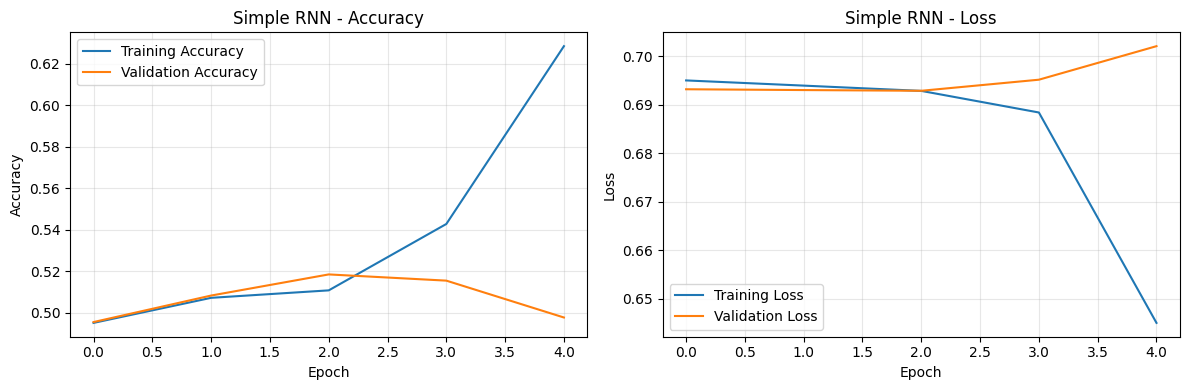

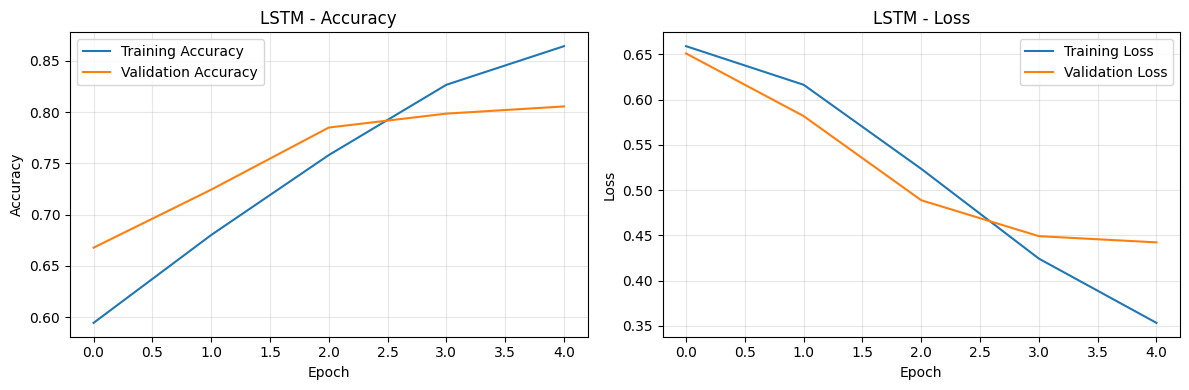

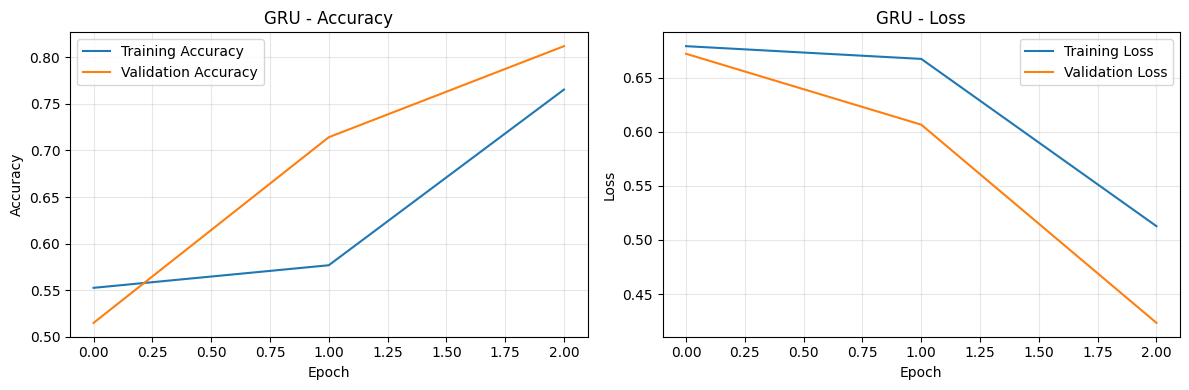

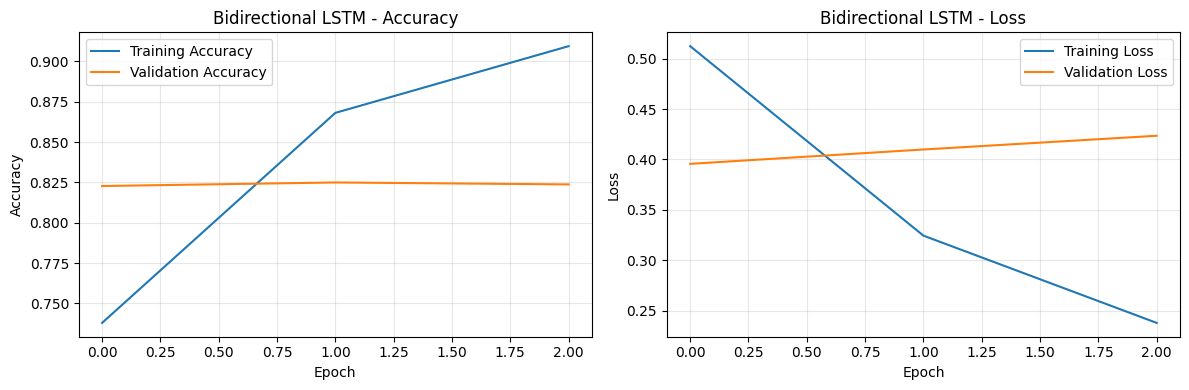

In [26]:
# Функція для побудови графіків accuracy та loss
def plot_training_history(history, title):
    # Створюємо фігуру з двома підграфіками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Графік точності (accuracy)
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Графік втрат (loss)
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Візуалізуємо результати для кожної основної моделі
plot_training_history(history_simple, "Simple RNN")
plot_training_history(history_lstm, "LSTM")
plot_training_history(history_gru, "GRU")
plot_training_history(history_bilstm, "Bidirectional LSTM")

In [22]:
# Експерименти з Vocab Size
# Тестуємо 3 різні розміри словника
vocab_sizes = [5000, 10000, 15000]

for vocab_size_exp in vocab_sizes:
    print(f"Вокабуляр розміром {vocab_size_exp}...")

    # Створюємо новий токенізатор з іншим vocab_size
    tokenizer_temp = Tokenizer(num_words=vocab_size_exp, oov_token="<OOV>")
    tokenizer_temp.fit_on_texts(train_texts)

    # Конвертуємо тексти з новим токенізатором
    train_seq_temp = tokenizer_temp.texts_to_sequences(train_texts)
    test_seq_temp = tokenizer_temp.texts_to_sequences(test_texts)

    # Додаємо padding
    train_pad_temp = pad_sequences(train_seq_temp, maxlen=max_length, padding='post')
    test_pad_temp = pad_sequences(test_seq_temp, maxlen=max_length, padding='post')

    # Створюємо модель з новим vocab_size
    model_temp = models.Sequential([
        layers.Embedding(vocab_size_exp, 64, input_length=max_length),  # Новий vocab_size
        layers.LSTM(32, return_sequences=True),
        layers.LSTM(16),
        layers.Dense(1, activation='sigmoid')
    ])

    model_temp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Навчаємо модель
    history_temp = model_temp.fit(
        train_pad_temp, train_labels,
        epochs=3,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    # Оцінюємо модель
    test_loss_temp, test_acc_temp = model_temp.evaluate(test_pad_temp, test_labels, verbose=0)

    # Зберігаємо результат
    experiment_results.append({
        'model': f'Vocab Size {vocab_size_exp}',
        'test_accuracy': test_acc_temp,
        'test_loss': test_loss_temp,
        'params': {'vocab_size': vocab_size_exp}
    })

    print(f"Vocab Size: {vocab_size_exp}, Тестова точність: {test_acc_temp:.4f}")

Вокабуляр розміром 5000...
Vocab Size: 5000, Тестова точність: 0.8335
Вокабуляр розміром 10000...
Vocab Size: 10000, Тестова точність: 0.8398
Вокабуляр розміром 15000...
Vocab Size: 15000, Тестова точність: 0.8277


In [23]:
# Експерименти з Max Length
# Тестуємо 3 різні максимальні довжини
max_lengths = [50, 100, 150]

for max_len_exp in max_lengths:
    print(f"\nМаксимальна довжина {max_len_exp}...")

    # Створюємо послідовності з новою довжиною
    train_pad_temp = pad_sequences(train_sequences, maxlen=max_len_exp, padding='post')
    test_pad_temp = pad_sequences(test_sequences, maxlen=max_len_exp, padding='post')

    # Створюємо модель з новою input_length
    model_temp = models.Sequential([
        layers.Embedding(vocab_size, 64, input_length=max_len_exp),  # Нова довжина
        layers.LSTM(32, return_sequences=True),
        layers.LSTM(16),
        layers.Dense(1, activation='sigmoid')
    ])

    model_temp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Навчаємо модель
    history_temp = model_temp.fit(
        train_pad_temp, train_labels,
        epochs=3,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    # Оцінюємо модель
    test_loss_temp, test_acc_temp = model_temp.evaluate(test_pad_temp, test_labels, verbose=0)

    # Зберігаємо результат
    experiment_results.append({
        'model': f'Max Length {max_len_exp}',
        'test_accuracy': test_acc_temp,
        'test_loss': test_loss_temp,
        'params': {'max_length': max_len_exp}
    })

    print(f"Max Length: {max_len_exp}, Тестова точність: {test_acc_temp:.4f}")


Максимальна довжина 50...
Max Length: 50, Тестова точність: 0.8033

Максимальна довжина 100...
Max Length: 100, Тестова точність: 0.8218

Максимальна довжина 150...
Max Length: 150, Тестова точність: 0.8266


In [24]:
# Експерименти з Embedding Dimension
# Тестуємо 3 різні розмірності embedding
embedding_dims = [32, 64, 128]

for emb_dim_exp in embedding_dims:
    print(f"\nEmbedding dimension {emb_dim_exp}...")

    # Створюємо модель з новою embedding dimension
    model_temp = models.Sequential([
        layers.Embedding(vocab_size, emb_dim_exp, input_length=max_length),  # Нова розмірність
        layers.LSTM(32, return_sequences=True),
        layers.LSTM(16),
        layers.Dense(1, activation='sigmoid')
    ])

    model_temp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Навчаємо модель
    history_temp = model_temp.fit(
        train_padded, train_labels,
        epochs=3,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    # Оцінюємо модель
    test_loss_temp, test_acc_temp = model_temp.evaluate(test_padded, test_labels, verbose=0)

    # Зберігаємо результат
    experiment_results.append({
        'model': f'Embedding Dim {emb_dim_exp}',
        'test_accuracy': test_acc_temp,
        'test_loss': test_loss_temp,
        'params': {'embedding_dim': emb_dim_exp}
    })

    print(f"Embedding Dim: {emb_dim_exp}, Тестова точність: {test_acc_temp:.4f}")


Embedding dimension 32...
Embedding Dim: 32, Тестова точність: 0.5734

Embedding dimension 64...
Embedding Dim: 64, Тестова точність: 0.7845

Embedding dimension 128...
Embedding Dim: 128, Тестова точність: 0.7796


In [25]:
# Тестування на нових прикладах
# Функція для передбачення настрою тексту
def predict_sentiment(text, model, tokenizer, max_length=100):
    # Конвертуємо текст в послідовність
    sequence = tokenizer.texts_to_sequences([text])

    # Додаємо padding
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Робимо передбачення (отримуємо ймовірність)
    prediction = model.predict(padded)[0][0]

    # Інтерпретуємо результат
    sentiment = "Позитивний" if prediction > 0.5 else "Негативний"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return sentiment, confidence

# Приклади текстів для тестування
test_examples = [
    "This movie is absolutely amazing! I loved every minute of it.",
    "Terrible movie, complete waste of time and money.",
    "The movie was okay, nothing special but not bad either.",
    "Outstanding performance by the actors. Highly recommend!",
    "Boring and poorly written. Very disappointed.",
    "Great story with unexpected plot twists!"
]

print("Тестування на нових прикладах:")
for i, text in enumerate(test_examples, 1):
    sentiment, confidence = predict_sentiment(text, model_bilstm, tokenizer)
    print(f"\nПриклад {i}:")
    print(f"Текст: '{text}'")
    print(f"Передбачення: {sentiment} (впевненість: {confidence:.3f})")

Тестування на нових прикладах:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step

Приклад 1:
Текст: 'This movie is absolutely amazing! I loved every minute of it.'
Передбачення: Позитивний (впевненість: 0.983)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Приклад 2:
Текст: 'Terrible movie, complete waste of time and money.'
Передбачення: Негативний (впевненість: 0.979)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Приклад 3:
Текст: 'The movie was okay, nothing special but not bad either.'
Передбачення: Негативний (впевненість: 0.843)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Приклад 4:
Текст: 'Outstanding performance by the actors. Highly recommend!'
Передбачення: Позитивний (впевненість: 0.979)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Приклад 5:
Текст: 'Boring and poorly written. Very disappointed.'
Передбачення: Негативний (впевненість: 0.940)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Приклад 6:
Текст: 'Great story with unexpected plot twists!'
Передбачення: Позитивний (впевненість: 0.973)
